# Utils & Setup
- all taken from micrograd (https://github.com/karpathy/micrograd)

In [1]:
import math

import torch
import numpy as np

In [2]:
# you can ignore this cell

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root, format='svg'):
  dot = Digraph(format=format, graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


# Quick tour of micrograd

## The Value class

In [3]:
class Value:
  """Smaller subset of the full Value from micrograd. """

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    # builds a topological sort using DFS (recursion)
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

## Sample expression

In [4]:
# build a sample expression
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

# How does deep learning work?
- Let's create the expression of a neuron that takes two inputs, x1 and x2.
- There are two weights plus a bias, for a total of 3 parameters.
- The activation function will be a tanh (it's an S-looking curve).

## Math expression for a 2-input neuron

In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [6]:
o.data # tanh(2*-3 + 0*1 + 6.88)

0.7071067811865476

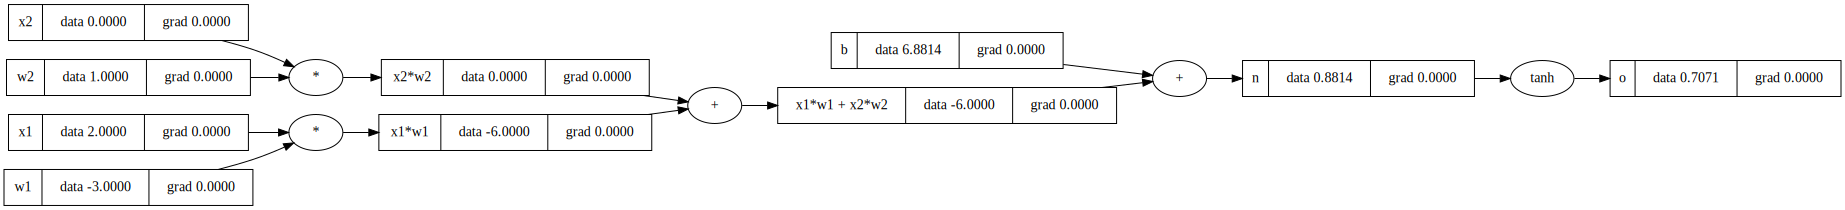

In [7]:
draw_dot(o)

## Let's backpropagate!
- we care about the derivative of o wrt to w1, w2, b
- those are called do/dw1; do/dw2; do/db respectively

In [8]:
o.backward() # will set o.grad to 1 and recurse

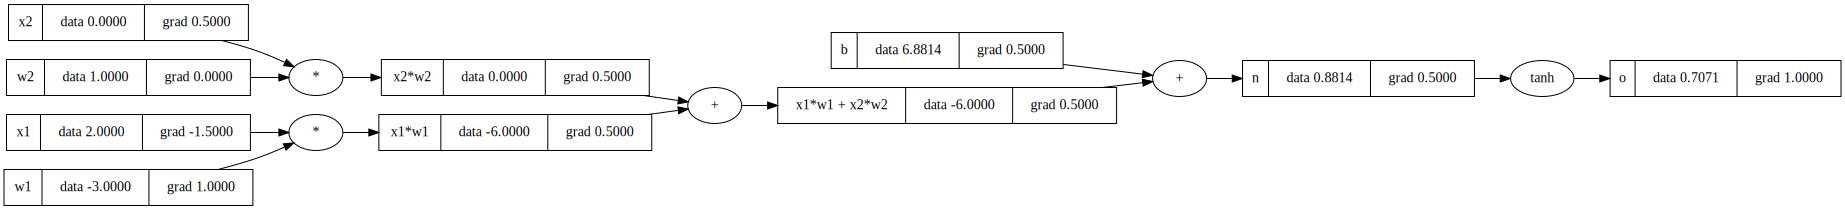

In [9]:
draw_dot(o) # now the graph shows the grad for o wrt to each node

## Manually verify some of the gradients

In [10]:
# o = tanh(n)
# do/dn = 1 - o**2
(1 - o.data**2)

0.4999999999999999

In [11]:
# our first chain rule example!
# intuition: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man"

# o = tanh(n)
# n = x1*w1 + x2*w2 + b
# do/db = do/dn * dn/db
(1 - o.data**2) * 1 

0.4999999999999999

In [12]:
# derive for do/dj, where j is x1*w1+x2*w2


# In Pytorch
- And finally we can see that Pytorch is just doing the same thing!

In [13]:
# this is what that same expression looks like in Pytorch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

## Verify output and backpropagate in Pytorch

In [14]:
print(o.data.item())
o.backward()

0.7071066904050358


## Are the numbers correct?

In [15]:
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
